In [1]:
def plot_feature_distribution(data, column_name, title):
    """
   Different histograms

    Args:
        data (pd.DataFrame):  input Data
        column_name (str): numerical

    """
    plt.figure(figsize=(8, 5))
    sns.histplot(data[column_name], kde=True)
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.savefig(f'{column_name}_distribution.png')
    plt.show()
    plt.close()

def plot_two_class_percentage(data, category_col, title, filename):
    """
     plotting the percentage of each category

    Args:
        data (pd.DataFrame): The input DataFrame
        category_col (str): categorical column.
        title (str): title
    """
    category_status_counts = data.groupby([category_col, 'readmitted_30_days']).size().reset_index(name='count')
    category_totals = data.groupby(category_col).size().reset_index(name='total')
    category_status_percentage = pd.merge(category_status_counts, category_totals, on=category_col)
    category_status_percentage['percentage'] = category_status_percentage['count'] / category_status_percentage['total']
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_col, y='percentage', hue='readmitted_30_days', data=category_status_percentage, palette='viridis')
    plt.title(title)
    plt.xlabel(category_col)
    plt.ylabel('Percentage')
    plt.ylim(0, 1)
    plt.legend(title='Readmitted (0=No, 1=Yes)')
    plt.savefig(filename)
    plt.show()
    plt.close()

 Data Verification
Missing Values:
 patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64
Duplicates: 0

Class Distribution:
 readmitted_30_days
0    0.675
1    0.325
Name: proportion, dtype: float64

Numerical data Summary:
               age  num_previous_admissions  length_of_stay
count  200.000000               200.000000      200.000000
mean    53.720000                 1.600000        7.865000
std     21.294574                 1.310951        4.134276
min     20.000000                 0.000000        1.000000
25%     34.000000                 1.000000        4.000000
50%     54.000000                 1.000000        8.000000
75%     73.000000                 2.000000       11.000000
max     89.000000                 6.000000       14.000000

Categorical Counts:
 g

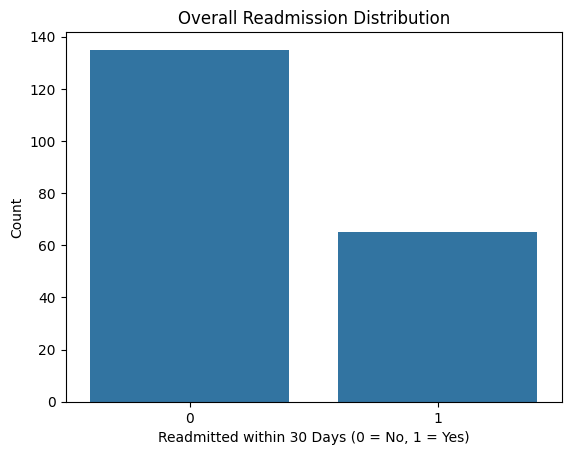

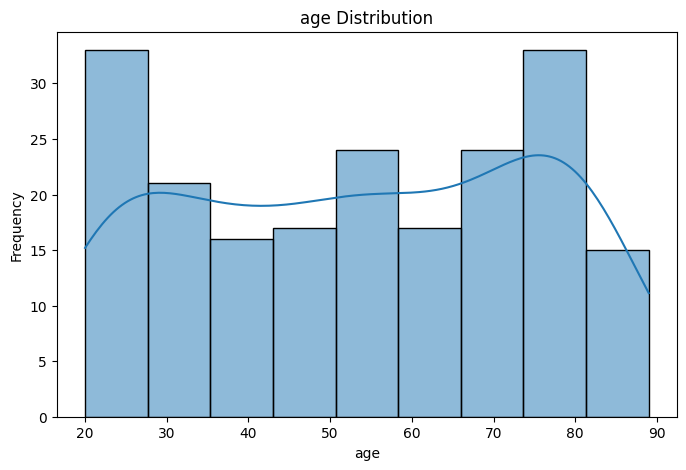

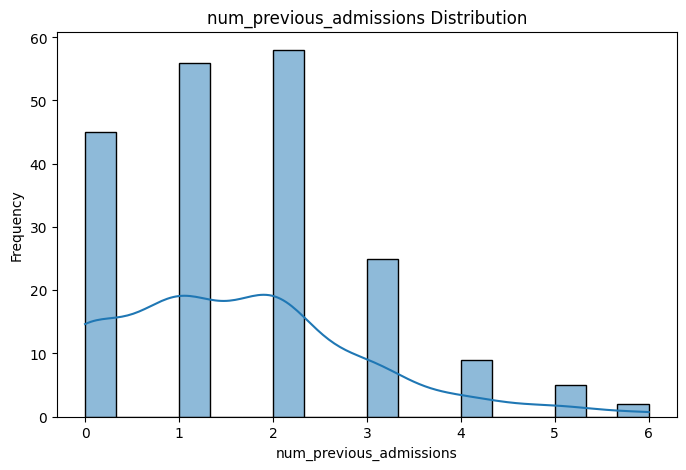

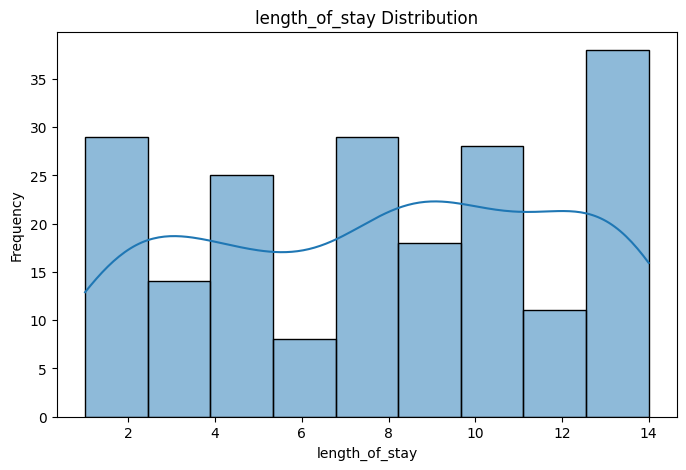

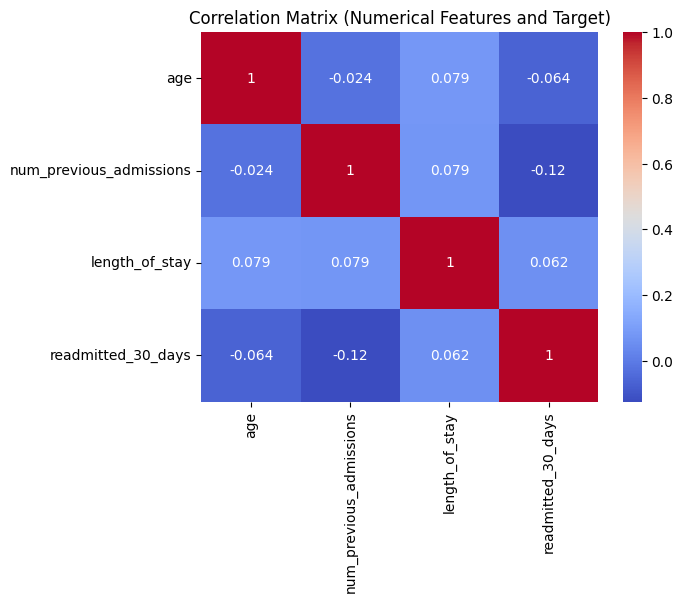

Training set shape: (140, 7)
Validation set shape: (30, 7)
Test set shape: (30, 7)
Class Distribution (Original Training Set):
 readmitted_30_days
0    0.671429
1    0.328571
Name: proportion, dtype: float64
Full X_train combined shape: (140, 67)

Analyzing XGBoost Feature Importance before SMOTE
Top 20 Most Important Features (XGBoost on full set):
alternative: 0.2046
activity: 0.1098
advised: 0.1017
has_surgery: 0.0580
diagnosis_code_D001: 0.0446
antibiotics: 0.0407
num_previous_admissions: 0.0366
medication: 0.0353
age: 0.0314
length_of_stay: 0.0297
medication_type_Type B: 0.0278
stable: 0.0278
blood: 0.0270
gender_Female: 0.0260
diagnosis_code_D002: 0.0242
has_followup: 0.0234
diagnosis_code_D003: 0.0225
recovery: 0.0222
medication_type_Type A: 0.0219
medication_type_Type C: 0.0212


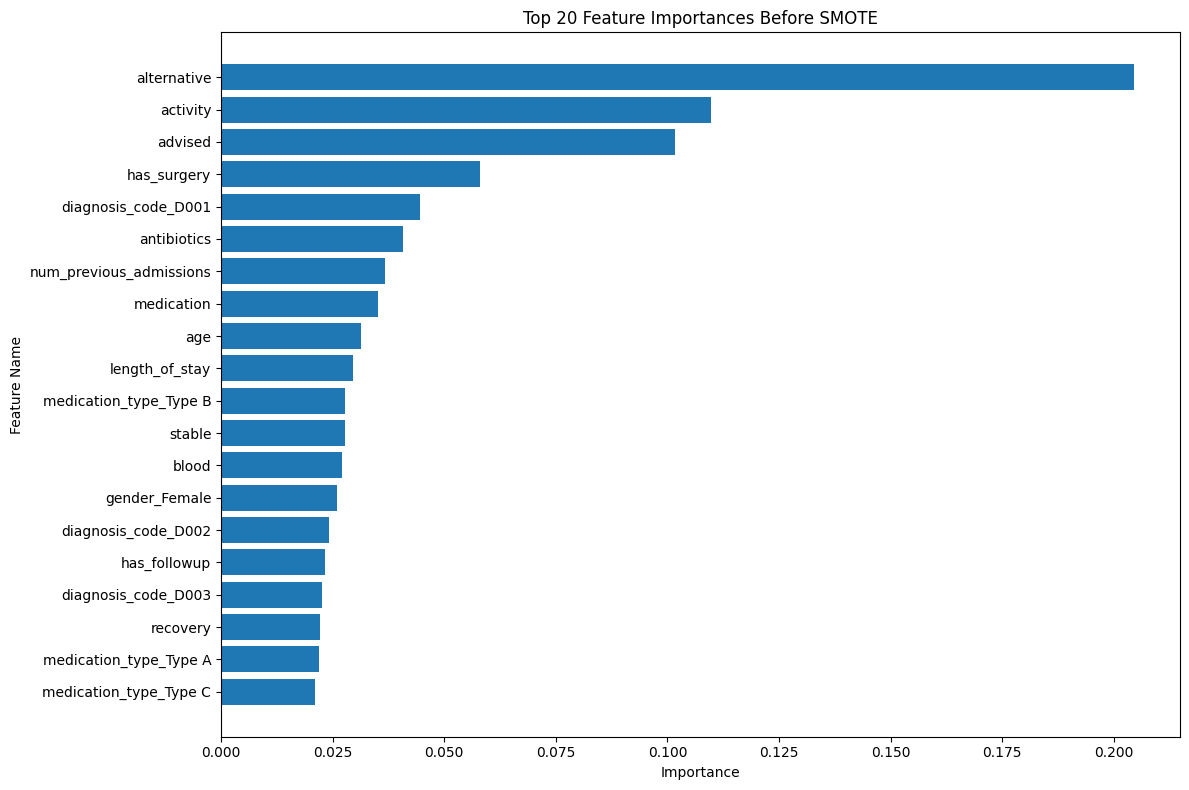


SMOTE to Training Data
Class Dist BEFORE SMOTE (Training data):
 readmitted_30_days
0    0.671429
1    0.328571
Name: proportion, dtype: float64
Class Dist AFTER SMOTE (Training dta):
 readmitted_30_days
0    0.5
1    0.5
Name: proportion, dtype: float64
X_train combined after SMOTE: (188, 67)


In [2]:
# Hospital Readmission Prediction
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import scipy.sparse as sp
import numpy as np
import re


# Load dataset
data = pd.read_csv('Assignment_Data.csv')
print(" Data Verification")
print("Missing Values:\n", data.isnull().sum())
print("Duplicates:", data.duplicated().sum())
print("\nClass Distribution:\n", data['readmitted_30_days'].value_counts(normalize=True))
print("\nNumerical data Summary:\n", data[['age', 'num_previous_admissions', 'length_of_stay']].describe())
print("\nCategorical Counts:\n", data[['gender', 'diagnosis_code', 'medication_type']].nunique())

# EDA
print("\ EDA Plots")

# Readmission Distribution
sns.countplot(x='readmitted_30_days', data=data)
plt.title('Overall Readmission Distribution')
plt.xlabel('Readmitted within 30 Days (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('overall_class_distribution.png')
plt.show()
plt.close()

#Feature Distributions
for col in ['age', 'num_previous_admissions', 'length_of_stay']:
    plot_feature_distribution(data, col, f'{col} Distribution')


#Correlation Matrix for numerical variable and target variable
sns.heatmap(data[['age', 'num_previous_admissions', 'length_of_stay', 'readmitted_30_days']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features and Target)')
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

#Train and test data Split
X = data.drop(['readmitted_30_days', 'patient_id'], axis=1)
y = data['readmitted_30_days']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print("Class Distribution (Original Training Set):\n", pd.Series(y_train).value_counts(normalize=True))

#Feature Engineering
#numerical and categorical columns
numerical_cols = ['age', 'num_previous_admissions', 'length_of_stay']
categorical_cols = ['gender', 'medication_type', 'diagnosis_code']
#Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled = scaler.transform(X_val[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])
#derived features
X_train_derived = X_train.assign(
    has_followup=X_train['discharge_note'].str.contains('follow-up|appointment', case=False, na=False).astype(int),
    has_surgery=X_train['discharge_note'].str.contains('surgery', case=False, na=False).astype(int),
)[['has_followup', 'has_surgery']]

X_val_derived = X_val.assign(
    has_followup=X_val['discharge_note'].str.contains('follow-up|appointment', case=False, na=False).astype(int),
    has_surgery=X_val['discharge_note'].str.contains('surgery', case=False, na=False).astype(int),
)[['has_followup', 'has_surgery']]

X_test_derived = X_test.assign(
    has_followup=X_test['discharge_note'].str.contains('follow-up|appointment', case=False, na=False).astype(int),
    has_surgery=X_test['discharge_note'].str.contains('surgery', case=False, na=False).astype(int),
)[['has_followup', 'has_surgery']]


#Encoding categorical features
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore', max_categories=5)
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_val_encoded = encoder.transform(X_val[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

#TF-IDF for discharge notes (Unigrams)
tfidf_max_features = 200
tfidf = TfidfVectorizer(max_features=tfidf_max_features, stop_words='english', ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train['discharge_note'])
X_val_tfidf = tfidf.transform(X_val['discharge_note'])
X_test_tfidf = tfidf.transform(X_test['discharge_note'])

# Combine ALL features
numerical_feature_names = numerical_cols
derived_feature_names = X_train_derived.columns.tolist()
categorical_feature_names = encoder.get_feature_names_out().tolist()
tfidf_feature_names = tfidf.get_feature_names_out().tolist()

all_feature_names = numerical_feature_names + derived_feature_names + categorical_feature_names + tfidf_feature_names
X_train_combined_full = sp.hstack([
    sp.csr_matrix(X_train_scaled),
    sp.csr_matrix(X_train_derived),
    X_train_encoded,
    X_train_tfidf
])
X_val_combined_full = sp.hstack([
    sp.csr_matrix(X_val_scaled),
    sp.csr_matrix(X_val_derived),
    X_val_encoded,
    X_val_tfidf
])
X_test_combined_full = sp.hstack([
    sp.csr_matrix(X_test_scaled),
    sp.csr_matrix(X_test_derived),
    X_test_encoded,
    X_test_tfidf
])
print(f"Full X_train combined shape: {X_train_combined_full.shape}")


#XGBoost Feature Importance(Before applying SMOTE)
print("\nAnalyzing XGBoost Feature Importance before SMOTE")
xgb_temp_importance_model = XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=100) # Use reasonable defaults
xgb_temp_importance_model.fit(X_train_combined_full, y_train)

#map to names back to features after importance
importances_xgb_full = xgb_temp_importance_model.feature_importances_
feature_importance_mapping = {i: name for i, name in enumerate(all_feature_names)}
sorted_indices_xgb = np.argsort(importances_xgb_full)[::-1]
sorted_importances_xgb = importances_xgb_full[sorted_indices_xgb]
sorted_feature_names_xgb = [feature_importance_mapping[i] for i in sorted_indices_xgb]
top_n_features = 20
print(f"Top {top_n_features} Most Important Features (XGBoost on full set):")
for i in range(min(top_n_features, len(sorted_feature_names_xgb))):
    print(f"{sorted_feature_names_xgb[i]}: {sorted_importances_xgb[i]:.4f}")
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names_xgb[:top_n_features][::-1], sorted_importances_xgb[:top_n_features][::-1])
plt.title(f'Top {top_n_features} Feature Importances Before SMOTE')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.savefig('feature_importance_xgb_full_set.png')
plt.show()

print("\nSMOTE to Training Data")
smote = SMOTE(random_state=42)
X_train_combined_resampled, y_train_resampled = smote.fit_resample(X_train_combined_full, y_train)
print("Class Dist BEFORE SMOTE (Training data):\n", pd.Series(y_train).value_counts(normalize=True))
print("Class Dist AFTER SMOTE (Training dta):\n", pd.Series(y_train_resampled).value_counts(normalize=True))
print(f"X_train combined after SMOTE: {X_train_combined_resampled.shape}")

In [3]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name, param_grid=None):
    """
    Training with GridSearchCV,validation set, and plot the confusion matrix.

    Args:
        model: The base model
        X_train: Training  data.
        y_train: Training target data.
        X_val: Validation  data.
        y_val: Validation target data.
        model_name (str):  name of the model
        param_grid (dict, optional):  None.

    Returns:
        The trained model.
    """
    print(f"\nTraining {model_name} Model...")

    if param_grid is not None:
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        print(f"{model_name} Best Parameters:", grid_search.best_params_)
    else:
        model.fit(X_train, y_train)

    # Evaluation on validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)
    print(f"{model_name} AUC-ROC (Validation): {roc_auc_score(y_val, y_pred_proba):.4f}")
    print(f"{model_name} F1-Score (Validation): {f1_score(y_val, y_pred):.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'Confusion Matrix ({model_name})')
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

    return model


Training and Evaluation

Training Tuned XGBoost (Full Features) Model...
Tuned XGBoost (Full Features) Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost (Full Features) AUC-ROC (Validation): 0.5950
Tuned XGBoost (Full Features) F1-Score (Validation): 0.4444


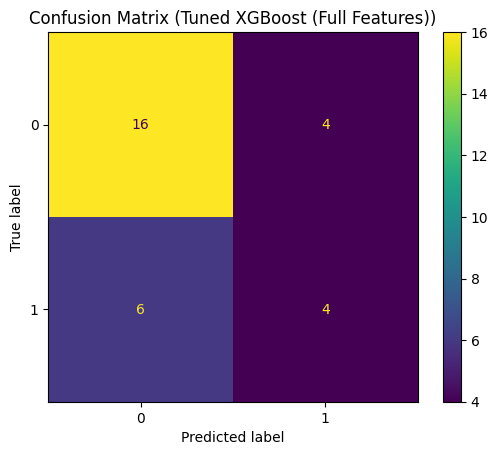


Training LR with Full Features Model...
LR with Full Features AUC-ROC (Validation): 0.3500
LR with Full Features F1-Score (Validation): 0.3333


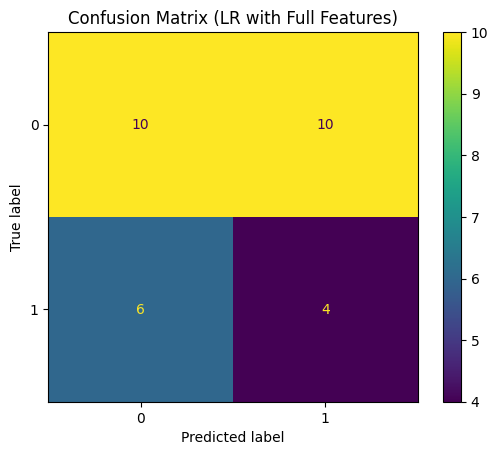

/tmp/ipython-input-24-1902846096.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_status_counts = data.groupby([category_col, 'readmitted_30_days']).size().reset_index(name='count')
/tmp/ipython-input-24-1902846096.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_totals = data.groupby(category_col).size().reset_index(name='total')


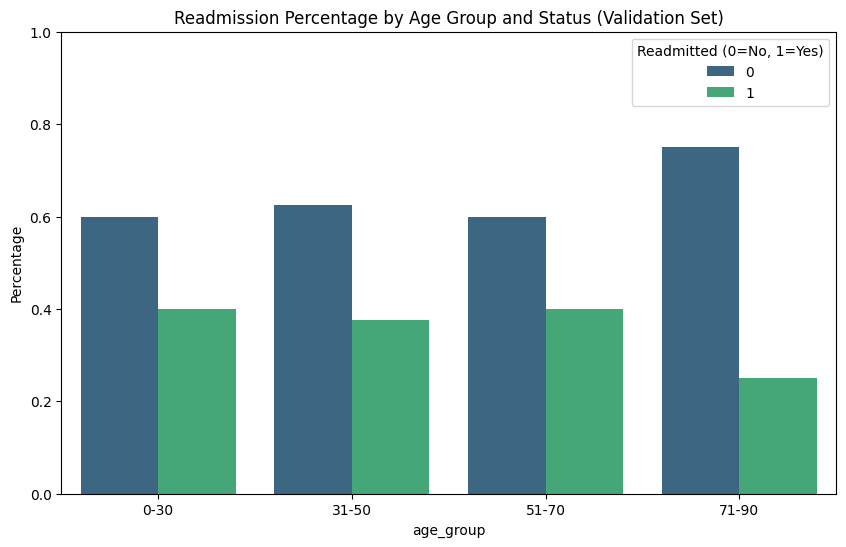

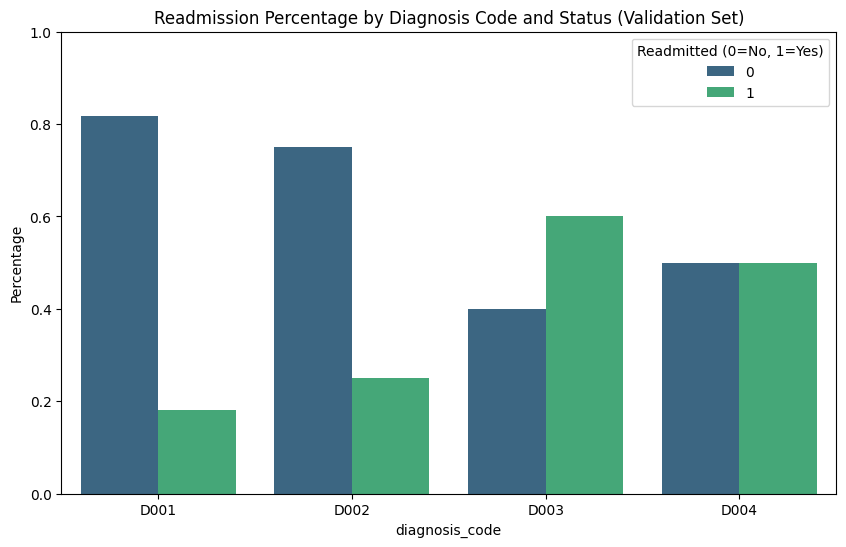

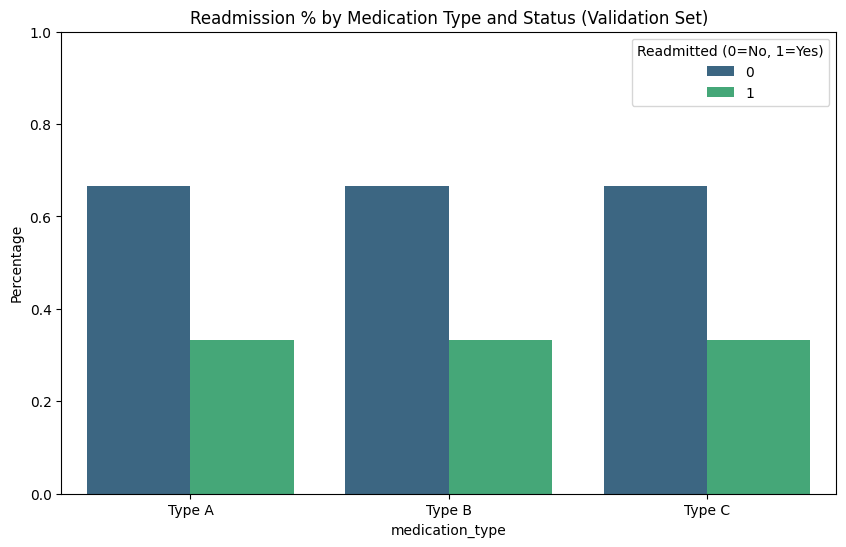

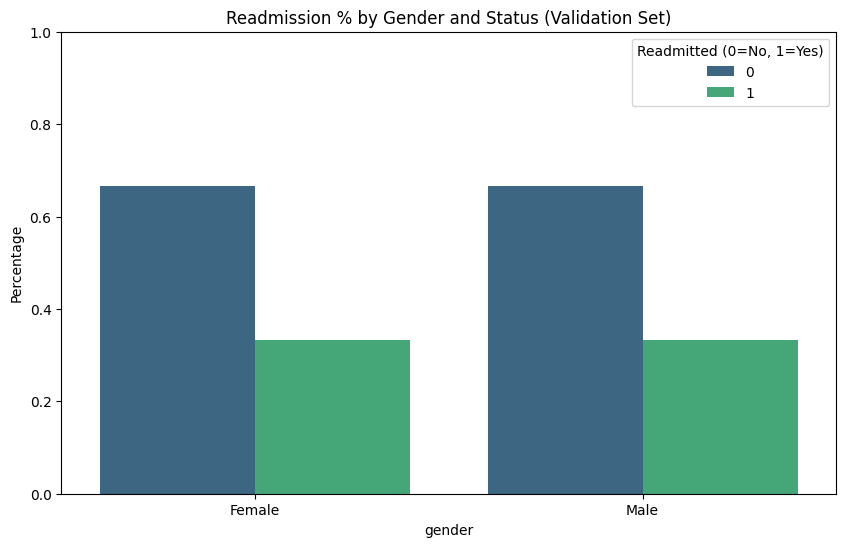

In [ ]:
#Model Training and Evaluation
print("\nTraining and Evaluation")

# XGBoost
model_xgb = train_and_evaluate_model(
    model=XGBClassifier(random_state=42, eval_metric='logloss'),
    X_train=X_train_combined_resampled,
    y_train=y_train_resampled,
    X_val=X_val_combined_full,
    y_val=y_val,
    model_name='Tuned XGBoost (Full Features)',
    param_grid={
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [100, 200],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
)

# LR Model
model_lr = train_and_evaluate_model(
    model=LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', C=0.05),
    X_train=X_train_combined_resampled,
    y_train=y_train_resampled,
    X_val=X_val_combined_full,
    y_val=y_val,
    model_name='LR with Full Features'
)


#Additional Visualizations
val_data_viz_combined = X_val.copy()
val_data_viz_combined['readmitted_30_days'] = y_val.values

# Age-wise Readmission %
age_bins = [0, 30, 50, 70, 90]
age_labels = ['0-30', '31-50', '51-70', '71-90']
val_data_viz_combined['age_group'] = pd.cut(val_data_viz_combined['age'], bins=age_bins, labels=age_labels, right=True)
plot_two_class_percentage(
    val_data_viz_combined.dropna(subset=['age_group']),
    'age_group',
    'Readmission Percentage by Age Group and Status (Validation Set)',
    'age_readmission_percentage_both_classes.png'
)

# Readmission % by Diagnosis Code
plot_two_class_percentage(
    val_data_viz_combined,
    'diagnosis_code',
    'Readmission Percentage by Diagnosis Code and Status (Validation Set)',
    'diagnosis_readmission_percentage_both_classes.png'
)

# Readmission % by Medication Type
plot_two_class_percentage(
    val_data_viz_combined,
    'medication_type',
    'Readmission % by Medication Type and Status (Validation Set)',
    'medication_readmission_percentage_both_classes.png'
)

# Readmission % by Gender
plot_two_class_percentage(
    val_data_viz_combined,
    'gender',
    'Readmission % by Gender and Status (Validation Set)',
    'gender_readmission_percentage_both_classes.png'
)


Training Tuned XGBoost - Selected Features Model...
Tuned XGBoost - Selected Features Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost - Selected Features AUC-ROC (Validation): 0.5900
Tuned XGBoost - Selected Features F1-Score (Validation): 0.3333


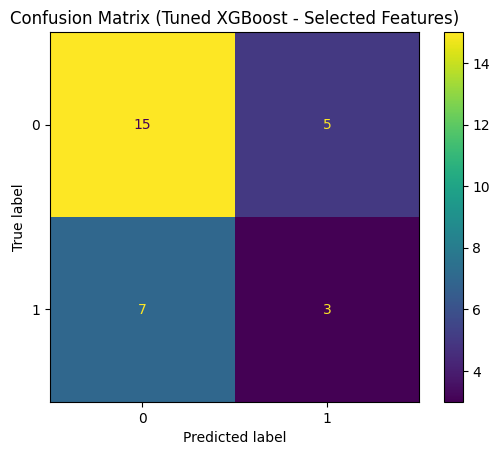


Training Logistic Regression - Selected Features Model...
Logistic Regression - Selected Features AUC-ROC (Validation): 0.3750
Logistic Regression - Selected Features F1-Score (Validation): 0.3333


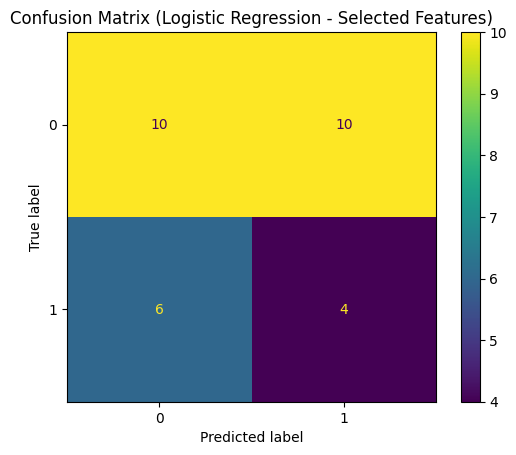

In [5]:
#Model Training
# XGBoost (important Selected Features)
model_xgb_selected = train_and_evaluate_model(
    model=XGBClassifier(random_state=42, eval_metric='logloss'),
    X_train=X_train_combined_selected_resampled,
    y_train=y_train_resampled_selected,
    X_val=X_val_combined_selected,
    y_val=y_val,
    model_name='Tuned XGBoost - Selected Features',
    param_grid={
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [100, 200],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
)

# LR with Selected Features
model_lr_selected = train_and_evaluate_model(
    model=LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', C=0.05),
    X_train=X_train_combined_selected_resampled,
    y_train=y_train_resampled_selected,
    X_val=X_val_combined_selected,
    y_val=y_val,
    model_name='Logistic Regression - Selected Features'
)

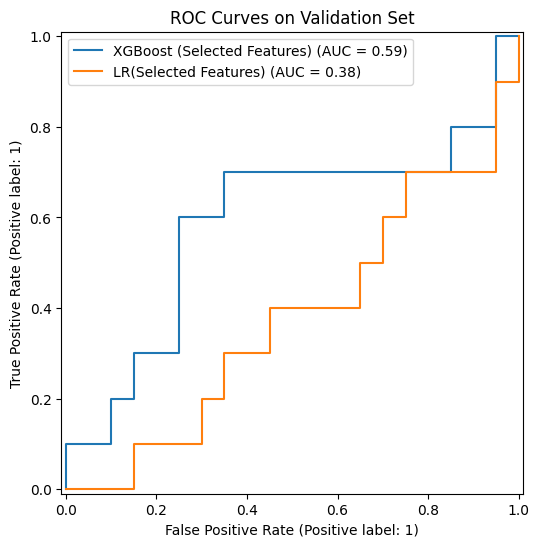

In [6]:
#ROC curves
from sklearn.metrics import RocCurveDisplay

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

RocCurveDisplay.from_estimator(
    model_xgb_selected,
    X_val_combined_selected,
    y_val,
    ax=ax,
    name="XGBoost (Selected Features)"
)

RocCurveDisplay.from_estimator(
    model_lr_selected,
    X_val_combined_selected,
    y_val,
    ax=ax,
    name="LR(Selected Features)"
)

plt.title('ROC Curves on Validation Set')
plt.legend()
plt.show()
plt.close(fig)

In [4]:
# Feature Selection based on XGBoost Importance
n_selected_features = 30
selected_feature_names = sorted_feature_names_xgb[:n_selected_features]
print(f"\nSelecting top {n_selected_features} features based on XGBoost Importance:")
print(selected_feature_names)
selected_indices = [all_feature_names.index(name) for name in selected_feature_names]
X_train_combined_selected = X_train_combined_full[:, selected_indices]
X_val_combined_selected = X_val_combined_full[:, selected_indices]
X_test_combined_selected = X_test_combined_full[:, selected_indices]

print(f"\nX_train combined (selected features) shape: {X_train_combined_selected.shape}")
print(f"X_val combined (selected features) shape: {X_val_combined_selected.shape}")
print(f"X_test combined (selected features) shape: {X_test_combined_selected.shape}")
smote_selected = SMOTE(random_state=42)
X_train_combined_selected_resampled, y_train_resampled_selected = smote_selected.fit_resample(X_train_combined_selected, y_train)

print("\nClass Dist BEFORE SMOTE (Training Set - Selected Features):\n", pd.Series(y_train).value_counts(normalize=True))
print("Class Dist AFTER SMOTE (Training Set - Selected Features):\n", pd.Series(y_train_resampled_selected).value_counts(normalize=True))
print(f"X_train combined (selected features) shape after SMOTE: {X_train_combined_selected_resampled.shape}")


Selecting top 30 features based on XGBoost Importance:
['alternative', 'activity', 'advised', 'has_surgery', 'diagnosis_code_D001', 'antibiotics', 'num_previous_admissions', 'medication', 'age', 'length_of_stay', 'medication_type_Type B', 'stable', 'blood', 'gender_Female', 'diagnosis_code_D002', 'has_followup', 'diagnosis_code_D003', 'recovery', 'medication_type_Type A', 'medication_type_Type C', 'discharged', 'complications', 'patient', 'diagnosis_code_D004', 'trajectory', 'weeks', 'treatment', 'scan', 'resume', 'rest']

X_train combined (selected features) shape: (140, 30)
X_val combined (selected features) shape: (30, 30)
X_test combined (selected features) shape: (30, 30)

Class Dist BEFORE SMOTE (Training Set - Selected Features):
 readmitted_30_days
0    0.671429
1    0.328571
Name: proportion, dtype: float64
Class Dist AFTER SMOTE (Training Set - Selected Features):
 readmitted_30_days
0    0.5
1    0.5
Name: proportion, dtype: float64
X_train combined (selected features) shap

In [13]:
!pip freeze > requirements.txt

In [8]:
#NER Extraction from Discharge notes
#dataset
try:
    df = pd.read_csv('Assignment_Data.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'Assignment_Data.csv' not found. Please ensure the file is in the correct directory.")
    exit()

Dataset loaded successfully!


In [9]:
# Dropping rows when discharge_notes  NaN or empty strings
df_notes = df.dropna(subset=['discharge_note']).copy()
df_notes['discharge_note'] = df_notes['discharge_note'].astype(str).str.strip()
df_notes = df_notes[df_notes['discharge_note'] != '']['discharge_note']

if df_notes.empty:
    print("No valid  notes")
    exit()
print(f"\n {len(df_notes)} discharge notes for NER")


 200 discharge notes for NER


In [10]:
pd.set_option('display.max_colwidth', None)
unique = df_notes.drop_duplicates()
unique
notes_list = unique.tolist()

In [11]:
from transformers import pipeline
import pandas as pd
import numpy as np
import re
import io

#LLM for Extraction - Flan-T5
try:
    extractor = pipeline("text2text-generation", model="google/flan-t5-base", device=-1)
    print("Flan-T5 model initialized")
except Exception as e:
    print(f"Error: {e}")
    exit()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Flan-T5 model initialized


In [12]:
def extract_entities_with_llm(note_text, extractor_pipeline):
    """
    a simple LLM with small prompt engineering to extract then labeling list of entities from a discharge note.
    """
    prompt = f"""
    Extract the following clinical entities from the discharge note.
    List each entity type followed by the extracted terms. If no terms are found for an entity type, state "None".

    Entity types to extract:
    - diagnosis
    - treatment
    - symptoms
    - medications
    - follow_up_actions

    Example:
    Discharge Note: "Stable post-surgery. Advised to avoid physical exertion."
    Output:
    diagnosis: None
    treatment: post-surgery
    symptoms: None
    medications: None
    follow_up_actions: avoid physical exertion

    Example:
    Discharge Note: "Discharge after recovery from pneumonia. No complications observed."
    Output:
    diagnosis: recovery from pneumonia
    treatment: pneumonia
    symptoms: None
    medications: None
    follow_up_actions: None

    Example:
    Discharge Note: "Patient showed improvement. Prescribed antibiotics for 5 days."
    Output:
    diagnosis: None
    treatment: Prescribed antibiotics for 5 days
    symptoms: None
    medications: antibiotics
    follow_up_actions: None

    Example:
    Discharge Note: "Blood pressure under control. Continue current medication."
    Output:
    diagnosis: Blood pressure
    treatment: Blood pressure under control
    symptoms: None
    medications: current medication
    follow_up_actions: Continue current medication

    Example:
    Discharge Note: "Good recovery trajectory. Follow-up scan scheduled next month."
    Output:
    diagnosis: None
    treatment: None
    symptoms: None
    medications: None
    follow_up_actions: Follow-up scan scheduled next month

    Example:
    Discharge Note: "No further signs of infection. Resume normal diet and activity."
    Output:
    diagnosis: None
    treatment: None
    symptoms: None
    medications: None
    follow_up_actions: Resume normal diet and activity

    Example:
    Discharge Note: "Patient discharged with minor discomfort. Advised rest and hydration."
    Output:
    diagnosis: None
    treatment: None
    symptoms: minor discomfort
    medications: None
    follow_up_actions: Advised rest and hydration

    Example:
    Discharge Note: "Patient discharged in stable condition. Recommend follow-up in 2 weeks."
    Output:
    diagnosis: None
    treatment: None
    symptoms: None
    medications: None
    follow_up_actions: Recommend follow-up in 2 weeks

    Now, for the following Discharge Note:
    Discharge Note: "{note_text}"

    Output:
    """
    try:

        response = extractor_pipeline(prompt, max_new_tokens=256, num_return_sequences=1,
                                      clean_up_tokenization_spaces=True, do_sample=False)
        generated_text = response[0]['generated_text'].strip()
        return generated_text

    except Exception as e:

        return f"Error: {e}"


# printing Entities for Each Note
print("\n")
extracted_results = []
for i, note in enumerate(notes_list):
    print(f"\nProcessing Note {i+1}:")
    print(f"Original Note: \"{note}\"")
    entities_output = extract_entities_with_llm(note, extractor)
    extracted_results.append(entities_output)
    print(f"Extracted Entities:\n{entities_output}")





Processing Note 1:
Original Note: "Good recovery trajectory. Follow-up scan scheduled next month."
Extracted Entities:
diagnosis: None treatment: None symptoms: None medications: None follow_up_actions: Follow-up scan scheduled next month

Processing Note 2:
Original Note: "Stable post-surgery. Advised to avoid physical exertion."
Extracted Entities:
diagnosis: None treatment: None symptoms: None medications: None follow_up_actions: avoid physical exertion

Processing Note 3:
Original Note: "Symptoms controlled. Monitoring for relapse advised."
Extracted Entities:
diagnosis: None treatment: None symptoms: None medications: None follow_up_actions: None

Processing Note 4:
Original Note: "Discharge after recovery from pneumonia. No complications observed."
Extracted Entities:
diagnosis: recovery from pneumonia treatment: pneumonia symptoms: None medications: None follow_up_actions: None

Processing Note 5:
Original Note: "Patient discharged in stable condition. Recommend follow-up in 